# Testing YOLO v3 - Objects Detection 
Using dnn OpenCV library for loading model of Neural Network from configuration file.

### OpenCV's DNN Module
OpenCV's dnn module provides a versatile interface for deploying pre-trained deep learning models. It offers support for various frameworks like Caffe, TensorFlow, and PyTorch, enabling seamless integration with different model formats. By loading a model's configuration file and weights, you can effectively utilize the pre-trained network for inference tasks.

### COCO Dataset and Pre-trained Weights
The COCO dataset is a large-scale image dataset containing objects labeled with bounding boxes and categories. Many state-of-the-art object detection models are trained on this dataset, resulting in powerful pre-trained weights. By using a model trained on COCO, you can benefit from its ability to recognize a wide range of objects, even if your specific task involves a different dataset or object categories.

# Importing Libraries

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

# 📂 Loading COCO class labels from file

In [3]:
# Opening file, reading, eliminating whitespaces, and splitting by '\n', which in turn creates list
labels = open('coco.names').read().strip().split('\n')  # list of names

In [5]:
labels[:5] # whole list is too long to print here

['person', 'bicycle', 'car', 'motorbike', 'aeroplane']

### Predefined weightes files

In [8]:
weights_path = 'yolov3.weights'
configuration_path = 'yolov3.cfg'

### Hyper parameters

In [9]:
# Setting minimum probability to eliminate weak predictions
probability_minimum = 0.5

# Setting threshold for non maximum suppression
threshold = 0.3

# Loading trained YOLO Objects Detector with DNN Help

In [12]:
network = cv2.dnn.readNetFromDarknet(configuration_path, weights_path)
# Getting names of all layers
layers_names_all = network.getLayerNames()  # list of layers' names

In [14]:
# Getting all layer names
layer_names_all = network.getLayerNames()

# Getting only output layers' names that we need from YOLO algorithm
try:
    # For versions where getUnconnectedOutLayers() returns a 2D array
    layers_names_output = [layer_names_all[i[0] - 1] for i in network.getUnconnectedOutLayers()]
except IndexError:
    # For versions where getUnconnectedOutLayers() returns a 1D array
    layers_names_output = [layer_names_all[i - 1] for i in network.getUnconnectedOutLayers()]

# Check point
print(layers_names_output)  # ['yolo_82', 'yolo_94', 'yolo_106']

['yolo_82', 'yolo_94', 'yolo_106']


# Loading input Sample image from file

In [16]:
# Our image initially is in RGB format
# But now we open it in BGR format as function 'cv2.imread' opens it so
image_input = cv2.imread('shocked_cat.jpeg')

# Getting image shape
image_input_shape = image_input.shape

# Check point
print(image_input_shape) 

(183, 275, 3)


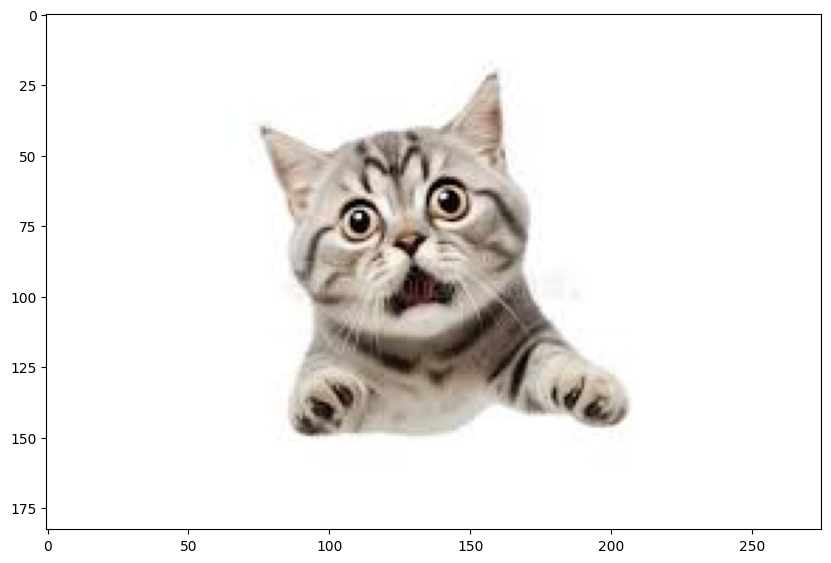

In [17]:
# Showing RGB image but firstly converting it from BGR format
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()

# BLOB
blobs serve as a fundamental data structure that bridges the gap between raw image data and the computational requirements of deep neural networks, enabling efficient and effective image processing.

The preprocessed image is converted into a 4-dimensional array (N, C, H, W), where:
N: Number of images in the batch (usually 1 for a single image).   
C: Number of channels (e.g., 3 for RGB images).   
H: Height of the image.
W: Width of the image.

# 💡 Getting blob from input image

In [18]:
# The 'cv2.dnn.blobFromImage' function returns 4-dimensional blob
# from input image after mean subtraction, normalizing, and RB channels swapping
# Resulted shape has number of images, number of channels, width and height
# E.G.: blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size, mean, swapRB=True)
# Link: https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/
blob = cv2.dnn.blobFromImage(image_input, 1 / 255.0, (416, 416), swapRB=True, crop=False)

# Check point
print(image_input.shape)  # (917, 1222, 3)
print(blob.shape)  # (1, 3, 416, 416)

(183, 275, 3)
(1, 3, 416, 416)


(416, 416, 3)


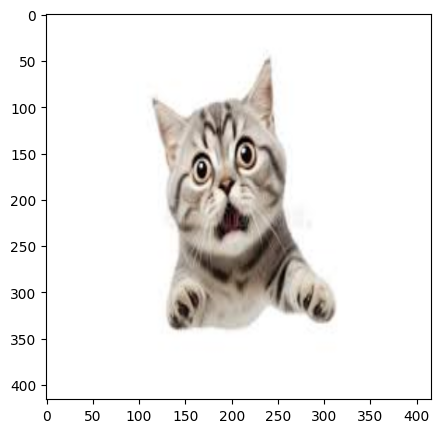

In [19]:
# Check point
# Slicing blob and transposing to make channels come at the end
blob_to_show = blob[0, :, :, :].transpose(1, 2, 0)
print(blob_to_show.shape)  # (416, 416, 3)

# Showing 'blob_to_show'
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(blob_to_show)
plt.show()

# Implementing forward pass with Blob

In [22]:
network.setInput(blob)  # setting blob as input to the network
output_from_network = network.forward(layers_names_output)

In [23]:
# Check point
print(type(output_from_network))  # <class 'list'>
print(type(output_from_network[0]))  # <class 'numpy.ndarray'>

<class 'tuple'>
<class 'numpy.ndarray'>


# Give Each Object a Unique Colour by Random Function

In [24]:
# Seed the generator - every time we run the code it will generate by the same rules
# In this way we can keep specific colour the same for every class
np.random.seed(42)
# randint(low, high=None, size=None, dtype='l')
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

# Check point
print(colours.shape)  # (80, 3)
print(colours[0])  # [102 220 225]

(80, 3)
[102 220 225]


# Bounding boxes Params

In [25]:
# Preparing lists for detected bounding boxes, obtained confidences and class's number
bounding_boxes = []
confidences = []
class_numbers = []

In [26]:
# Getting spacial dimension of input image
h, w = image_input_shape[:2]  # Slicing from tuple only first two elements

# Check point
print(h, w)  # 917 1222

183 275


#  Passing Image thorugh Yolo Network

In [27]:
for result in output_from_network:
    # Going through all detections from current output layer
    for detection in result:
        # Getting class for current object
        scores = detection[5:]
        class_current = np.argmax(scores)

        # Getting confidence (probability) for current object
        confidence_current = scores[class_current]

        # Eliminating weak predictions by minimum probability
        if confidence_current > probability_minimum:
            # Scaling bounding box coordinates to the initial image size
            # YOLO data format keeps center of detected box and its width and height
            # That is why we can just elementwise multiply them to the width and height of the image
            box_current = detection[0:4] * np.array([w, h, w, h])

            # From current box with YOLO format getting top left corner coordinates
            # that are x_min and y_min
            x_center, y_center, box_width, box_height = box_current.astype('int')
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))

            # Adding results into prepared lists
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)

# IOU and Non Max Supression to Remove Duplicates Boxes

In [28]:
# It is needed to make sure the data type of the boxes is 'int'
# and the type of the confidences is 'float'
# https://github.com/opencv/opencv/issues/12789
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

# Check point
# Showing labels of the detected objects
for i in range(len(class_numbers)):
    print(labels[int(class_numbers[i])])

# Saving found labels
with open('found_labels.txt', 'w') as f:
    for i in range(len(class_numbers)):
        f.write(labels[int(class_numbers[i])])

cat
cat
cat
cat
cat
cat


# Drawing bounding boxes and labels

In [29]:
# Checking if there is at least one detected object
if len(results) > 0:
    # Going through indexes of results
    for i in results.flatten():
        # Getting current bounding box coordinates
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]

        # Preparing colour for current bounding box
        colour_box_current = [int(j) for j in colours[class_numbers[i]]]

        # Drawing bounding box on the original image
        cv2.rectangle(image_input, (x_min, y_min), (x_min + box_width, y_min + box_height),
                      colour_box_current, 5)

        # Preparing text with label and confidence for current bounding box
        text_box_current = '{}: {:.4f}'.format(labels[int(class_numbers[i])], confidences[i])

        # Putting text with label and confidence on the original image
        cv2.putText(image_input, text_box_current, (x_min, y_min - 7), cv2.FONT_HERSHEY_SIMPLEX,
                    1.5, colour_box_current, 5)

# Showing Results

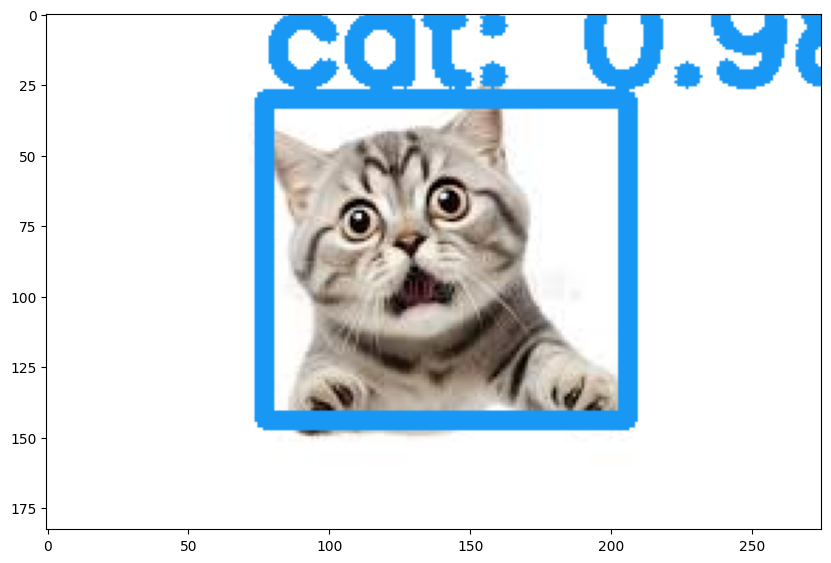

In [30]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()